In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


## Single Step Kalman Filter
$$
\begin{aligned}
&\textbf{Filter}\left(m_{t-1}, P_{t-1}, A, Q, H, R, y\right): \\
&\quad m_t^{-} = A m_{t-1} \quad \text{// predictive mean} \\
&\quad P_t^{-} = A P_{t-1} A^{\top} + Q \quad \text{// predictive covariance} \\
&\quad z = y - H m_t^{-} \quad \text{// residual} \\
&\quad S = H P_t^{-} H^{\top} + R \quad \text{// innovation covariance} \\
&\quad K = P_t^{-} H^{\top} S^{-1} \quad \text{// gain} \\
&\quad m_t = m_t^{-} + K z \quad \text{// updated mean} \\
&\quad P_t = (I - K H) P_t^{-} \quad \text{// updated covariance} \\
&\quad \textbf{return } (m_t, P_t), (m_t^{-}, P_t^{-})
\end{aligned}
$$

In [2]:
def filter(m_t_minus, P_t_minus, A, Q, H, R, y):
    m_t_minus = A @ m_t_minus
    P_t_minus = A @ P_t_minus @ A.T + Q
    z = y - H @ m_t_minus
    S = H @ P_t_minus @ H.T + R
    K = P_t_minus @ H.T @ np.linalg.inv(S)
    m_t = m_t_minus + K @ z 
    P_t = (np.eye(len(K)) - K @ H) @ P_t_minus
    return (m_t, P_t), (m_t_minus, P_t_minus)


def filter_light(m_t_minus, P_t_minus, A, Q, H, R, y):
    m_t_minus = A @ m_t_minus
    P_t_minus = A @ P_t_minus @ A.T + Q
    z = y - H @ m_t_minus
    S = H @ P_t_minus @ H.T + R
    K = P_t_minus @ H.T @ np.linalg.inv(S)
    m_t = m_t_minus + K @ z 
    P_t = (np.eye(len(K)) - K @ H) @ P_t_minus
    return m_t, P_t

def future_prediction(m_t_minus, P_t_minus, A, Q):
    m_t_minus = A @ m_t_minus
    P_t_minus = A @ P_t_minus @ A.T + Q
    return m_t_minus, P_t_minus


In [3]:
def smoother(m_t, P_t, A, m_t_plus_1_bar, P_t_plus_1_bar, m_t_plus_1_s, P_t_plus_1_s):
    G = P_t @ A.T @ np.linalg.inv(P_t_plus_1_bar)
    m_t_s = m_t + G @ (m_t_plus_1_s - m_t_plus_1_bar)
    P_t_s = P_t + G @ (P_t_plus_1_s - P_t_plus_1_bar) @ G.T
    return m_t_s, P_t_s

In [4]:
def predict(m_0, P_0, A_sequence, Q_sequence, H_sequence, y_sequence, R_sequence):

    # Initialize sequences with initial values
    m_sequence = [m_0]
    P_sequence = [P_0]
    
    # Get the number of time steps
    num_steps = len(A_sequence)
    
    # Iterate from t=1 onwards
    for t in range(num_steps):
        # Get current parameters
        A_t = A_sequence[t]
        Q_t = Q_sequence[t]
        H_t = H_sequence[t]
        y_t = y_sequence[t]
        R_t = R_sequence[t]
        
        # Get previous state estimates
        m_t_minus_1 = m_sequence[t]
        P_t_minus_1 = P_sequence[t]
        
        # Apply FILTER function
        (m_t, P_t), (m_t_minus, P_t_minus) = filter(m_t_minus_1, P_t_minus_1, A_t, Q_t, H_t, R_t, y_t)
        
        # Store results
        m_sequence.append(m_t)
        P_sequence.append(P_t)
    
    return m_sequence, P_sequence

The Setup for Kalman Filtering and Smoothing is a LGSSM of the form:
$$x_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$$
$$x_n | x_{n-1} \sim \mathcal{N}(A_n x_{n-1} + b_n, Q_n)$$
$$ z_n | x_n \sim \mathcal{N}(H_n x_n + c_n, R_n)$$
The parameters have are commonly refered to(at least in signal processing) as:
- $A_n$: 


It is important to understand that in Kalman Filtering A_n, Q_n, H_n, and R_n are assumed to be known. 

### First Example:
For simplicitly we reduce to a 1d case without time dependendence of the parameters. 

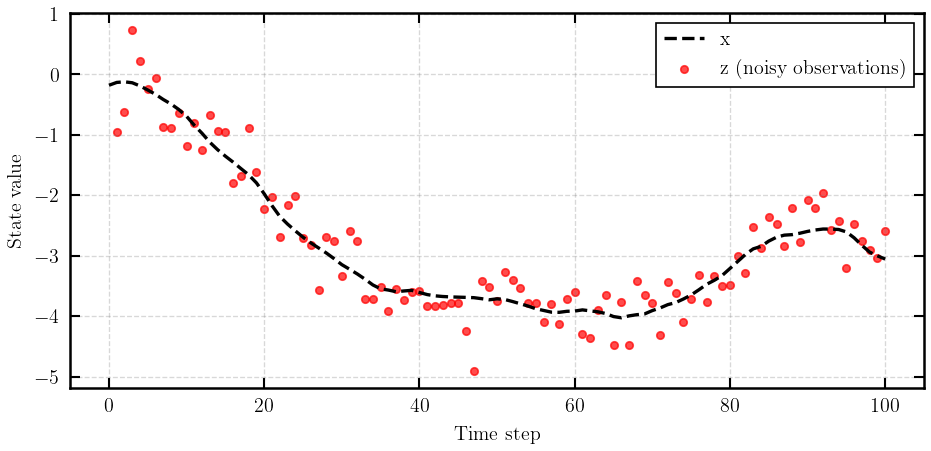

In [5]:
h = 0.1
sigma = 0.33
mu_0 = np.zeros(2)
Sigma_0 = np.eye(2)*0.33

A = np.array([[1, h], [0, 1]])
Q = np.array([[h**3/3, h**2/2], [h**2/2, h]])
H = np.array([[1, 0]])
R = np.array([[sigma]])

#Sample a true process
np.random.seed(6)
x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
x_sequence = [x_0]
z_sequence = []
for i in range(100):
    x_sequence.append(np.random.multivariate_normal(A @ x_sequence[-1], Q))
    z_sequence.append(np.random.normal(H @ x_sequence[-1], R))
x_sequence = np.array(x_sequence)
z_sequence = np.array(z_sequence).reshape(-1,1)


plt.figure(figsize=(8, 4))
plt.plot(x_sequence[:, 0], label='x', color='black', linestyle='--')
#plt.plot(x_sequence[:, 1], label='x[1] (velocity)')
plt.scatter(range(1,len(z_sequence)+1), z_sequence, color='red', s=20, alpha=0.7, label='z (noisy observations)')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def kalman_filter(t):

    m_sequence = [mu_0]
    P_sequence = [Sigma_0] 

    for t in range(t):
        m_prime, P_prime = filter_light(m_sequence[-1], P_sequence[-1], A, Q, H, R, z_sequence[t])
        m_sequence.append(m_prime)
        P_sequence.append(P_prime)

    m_future = [m_sequence[-1]]
    P_future = [P_sequence[-1]]
        
    if t == 0:
        for t in range(t, 100):
            m_next, P_next = future_prediction(m_future[-1], P_future[-1], A, Q)
            m_future.append(m_next)
            P_future.append(P_next)
    else:
        for t in range(t+1, 100):
            m_next, P_next = future_prediction(m_future[-1], P_future[-1], A, Q)
            m_future.append(m_next)
            P_future.append(P_next)

    m_projected = np.array(m_sequence)@H.T
    P_projected = np.array(P_sequence)[:,0,0]
    m_projected = m_projected.squeeze()
    P_projected = P_projected.squeeze()

    m_future_projected = np.array(m_future)@H.T
    P_future_projected = np.array(P_future)[:,0,0]
    m_future_projected = m_future_projected.squeeze()
    P_future_projected = P_future_projected.squeeze()

    return m_projected, P_projected, m_future_projected, P_future_projected

In [7]:
ts = np.arange(101)

In [8]:
def plot_kalman_filter(t, m_projected, P_projected, m_future_projected, P_future_projected):

    plt.figure(figsize=(8, 4))
    plt.plot(x_sequence[:, 0], label='ground truth', color='black', linestyle='--')
    plt.scatter(ts[1:], z_sequence, color='black', s=20, alpha=0.3)
    plt.scatter(ts[1:t+1], z_sequence[:t], s=20, alpha=0.7, label='observed data')

    plt.plot(ts[:t+1], m_projected, color='red', alpha=0.7, label='filtered estimate')
    plt.fill_between(ts[:t+1], m_projected - np.sqrt(P_projected), m_projected + np.sqrt(P_projected), color='red', alpha=0.2)

    plt.plot(ts[t:], m_future_projected, color='black', alpha=0.3, label='predicted future')
    plt.fill_between(ts[t:], m_future_projected - np.sqrt(P_future_projected), m_future_projected + np.sqrt(P_future_projected), color='black', alpha=0.2)

    #plt.axvline(x=t, color='black', alpha=0.3, label='current time')
    #plt.yticks(np.arange(-8, 2, 1))
    plt.ylim(-5, 1)
    plt.xlim(0, 100)

    plt.xlabel('Time')
    plt.ylabel('State')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    #plt.savefig(f'filter_imgs/kalman_filter_{t}.png')
    plt.close()



In [29]:
t=0
m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t)
plot_kalman_filter(t, m_projected, P_projected, m_future_projected, P_future_projected)

In [ ]:
for t in tqdm(range(1,101)):
    m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t)
    plot_kalman_filter(t, m_projected, P_projected, m_future_projected, P_future_projected)

100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


### Smoothing Procedure

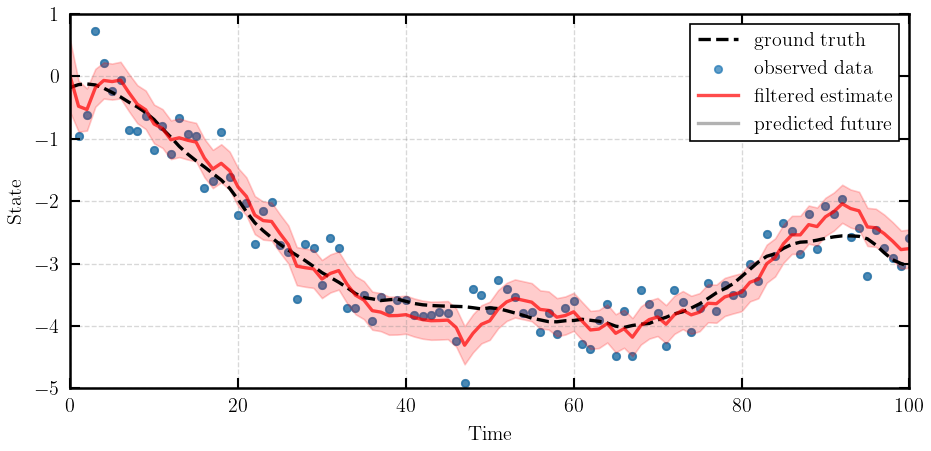

In [9]:
t=100
m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t)
plot_kalman_filter(t, m_projected, P_projected, m_future_projected, P_future_projected)

In [27]:
m_sequence = [mu_0]
P_sequence = [Sigma_0] 
m_sequence_predicted = [mu_0]
P_sequence_predicted = [Sigma_0]
for t in range(100):
    (m_prime, P_prime), (m_prime_predicted, P_prime_predicted) = filter(m_sequence[-1], P_sequence[-1], A, Q, H, R, z_sequence[t])
    m_sequence.append(m_prime)
    P_sequence.append(P_prime)
    m_sequence_predicted.append(m_prime_predicted)
    P_sequence_predicted.append(P_prime_predicted)

m_sequence = np.array(m_sequence)
P_sequence = np.array(P_sequence)
m_sequence_predicted = np.array(m_sequence_predicted)
P_sequence_predicted = np.array(P_sequence_predicted)

In [11]:
ts

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [20]:
print(m_sequence[-1])
print(m_sequence[100-1])

[-2.76048447 -0.39242705]
[-2.77635037 -0.50143927]


In [16]:
m_sequence[100]

array([-2.76048447, -0.39242705])

In [28]:
m_sequence.shape

m_smoothed = [m_sequence[-1]]
P_smoothed = [P_sequence[-1]]
for t in tqdm(range(1,101)):
    m_smoothed_previous, P_smoothed_previous = smoother(m_sequence[100-t], P_sequence[100-t], A, m_sequence_predicted[101-t], P_sequence_predicted[101-t], m_smoothed[-1], P_smoothed[-1])
    m_smoothed.append(m_smoothed_previous)
    P_smoothed.append(P_smoothed_previous)

#flip the smoothed sequence
m_smoothed = m_smoothed[::-1]
P_smoothed = P_smoothed[::-1]

m_smoothed = np.array(m_smoothed)
P_smoothed = np.array(P_smoothed)

m_smoothed_projected = m_smoothed@H.T
P_smoothed_projected = np.array(P_smoothed)[:,0,0]
m_smoothed_projected = m_smoothed_projected.squeeze()
P_smoothed_projected = P_smoothed_projected.squeeze()

m_projected = m_sequence@H.T
P_projected = np.array(P_sequence)[:,0,0]
m_projected = m_projected.squeeze()
P_projected = P_projected.squeeze()


100%|██████████| 100/100 [00:00<00:00, 78795.87it/s]


In [29]:
m_smoothed_projected.shape

(101,)

In [38]:
def plot_smoothed_estimate(t):
    plt.figure(figsize=(8, 4))
    plt.plot(x_sequence[:, 0], label='ground truth', color='black', linestyle='--')
    plt.scatter(ts[1:], z_sequence, s=20, alpha=0.7, label='observed data')
    plt.plot(ts[:t+1], m_projected[:t+1], color='red', alpha=0.7, label='filtered estimate')
    plt.fill_between(ts[:t+1], m_projected[:t+1] - np.sqrt(P_projected[:t+1]), m_projected[:t+1] + np.sqrt  (P_projected[:t+1]), color='red', alpha=0.2)

    plt.plot(ts[t:], m_smoothed_projected[t:], color='blue', alpha=0.7, label='smoothed estimate')
    plt.fill_between(ts[t:], m_smoothed_projected[t:] - np.sqrt(P_smoothed_projected[t:]),  m_smoothed_projected[t:] + np.sqrt(P_smoothed_projected[t:]), color='blue', alpha=0.2)

    #plt.axvline(x=t, color='black', alpha=0.3, label='current time')
    #plt.yticks(np.arange(-8, 2, 1))
    plt.ylim(-5, 1)
    plt.xlim(0, 100)
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.show()
    plt.savefig(f'smoother_imgs/kalman_filter_{t}.png')
    plt.close()

In [39]:
for t in range(101):
    plot_smoothed_estimate(t)

### EKF0

### EKF1
